## Following a Youtube Tutorial for GNNs ESOL data

Understanding Graph Neural Networks | Part 3/3 - Pytorch Geometric and Molecule Data using RDKit

In [2]:
# shouldn't directly use the smiles string
# using RDKit to turn it in to a graph representation

import rdkit
from torch_geometric.datasets import MoleculeNet
 
# Load the ESOL dataset
data = MoleculeNet(root='data/ESOL', name='ESOL')
data

# Investigating the dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
#print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

# Investigating the features
# Shape: [num_nodes, num_node_features]
data[0].x
# each row represents one node feature vector

data[0].edge_index.t()
# this is the adjacency list - shows which nodes are connected (the edges)

data[0].y
# this is the label, target value
# expresses the water soluability
# this is a graph0level prediction problem. only 1 prediction for each graph.



Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


tensor([[-0.7700]])

# converting SMILES to RDKit molecules

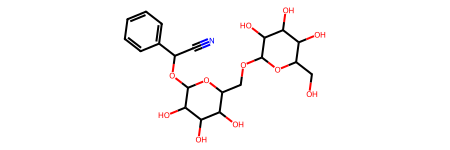

In [3]:
# this is already done in ESOL-- but for other datasets this might need to be done
data[0]["smiles"]

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

# layers come from torch gnn.nn
# using a simple message passing layer
class GCN(torch.nn.Module):
    # define our layers
    # shows 4 message passing layer
    # first one is a transformation layer
    # then a linear output layer that performs regression
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        # use embedding_size*2 due to the global pooling method of using 
        self.out = Linear(embedding_size*2, 1)

    # passing our node features and edge information
    # x is the node features
    # edge_index is the edge information
    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index) # first message passing step
        hidden = F.tanh(hidden) # activation function

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        # why do we do global pooling?
        # to combine node information so we can have 1 fixed representation for each molecule
        # combination of mean and max pooling -> embedding of the whole graph
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [5]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss() # define loss function and the optimizer (ADAM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)   # specify the learning rate

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64 # 64 in each batch
loader = DataLoader(data[:int(data_size * 0.8)],  # 80% of data to the train loader
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
# how does the DataLoader in PYG work? 
 # batching with graphs -- what happens? 
 # concating all node features in a matrix and combining adjacency matrix into a large adjancecny matrix
 # makes it seem like all graphs are one big one. basically takes apart each individual graphs. 
 # but the large adjacency matrix makes it so information is only passed between the same graphs. 
 # dataloader does some heavy lifting

def train(data): # iterate over batches
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     # calculate loss from the predictions 
      loss.backward()  
      # Update using the gradients
      optimizer.step()    # optimizes the model-- for each iteration. 
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000): # does 2000 epochs (500 cause I'm impatient)
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665947914123535
Epoch 100 | Train Loss 0.8507458567619324
Epoch 200 | Train Loss 1.1230734586715698
Epoch 300 | Train Loss 0.32148978114128113
Epoch 400 | Train Loss 0.24272656440734863
Epoch 500 | Train Loss 0.36963319778442383
Epoch 600 | Train Loss 0.24472765624523163
Epoch 700 | Train Loss 0.06413093954324722
Epoch 800 | Train Loss 0.1804855316877365
Epoch 900 | Train Loss 0.18056587874889374
Epoch 1000 | Train Loss 0.0514138787984848
Epoch 1100 | Train Loss 0.04122818633913994
Epoch 1200 | Train Loss 0.12115008383989334
Epoch 1300 | Train Loss 0.0661511942744255
Epoch 1400 | Train Loss 0.030933765694499016
Epoch 1500 | Train Loss 0.020755065605044365
Epoch 1600 | Train Loss 0.04185760021209717
Epoch 1700 | Train Loss 0.0188473928719759
Epoch 1800 | Train Loss 0.05332963541150093
Epoch 1900 | Train Loss 0.06158291921019554


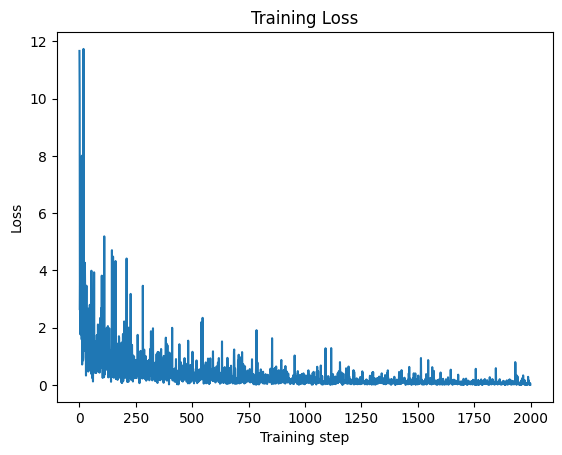

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
sns.lineplot(x=range(len(losses_float)), y=losses_float)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [ ]:
import pandas as pd 

# Analyze the results for one batch
# looking at the test data! 
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-1.400,-0.966595
1,-0.660,-0.475969
2,-4.883,-5.372324
3,-5.190,-5.197470
4,-2.210,-2.288759
...,...,...
59,-3.400,-3.332029
60,-3.120,-2.925303
61,-1.740,-2.170233
62,-1.210,-0.964223


<Axes: xlabel='y_real', ylabel='y_pred'>

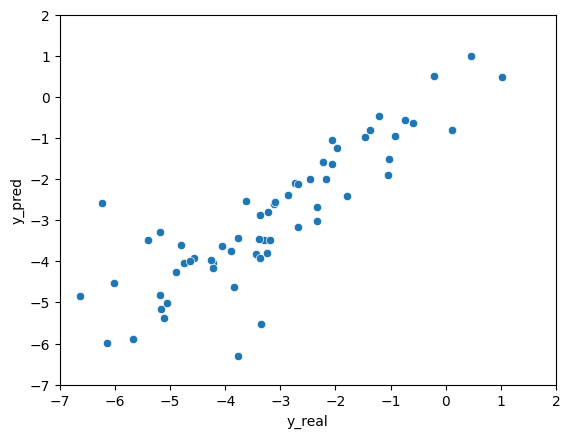

In [ ]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

# plotting the predictions vs. observed variables
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

For example you can add:

Dropouts
Other (more intelligent) Pooling Layers (all layers here: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#)
Global Pooling Layers
Batch Normalization
More MP layers
Other hidden state sizes
Test metrics (test error) and Hyperparameter optimization
...
https://github.com/rusty1s/pytorch_geometric/tree/master/examples